# Đánh giá mô hình
1. Vẽ biểu đồ d_loss và g_loss (trên từng epoch, với từng loại loss)
2. Đánh giá các điểm benchmark SSIM, PSNR trên các bộ dataset Set5, Set14 

In [1]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
from imutils.paths import list_images
from config import config
import imutils
import cv2
import tensorlayer as tl
import os
from model import get_G, get_D

## 2. Vẽ biểu đồ d_loss và g_loss

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
def plot_losses(losses_path,label,title,figure=1,color='b',n_iter=1):
    def losses_to_epoch_losses(lines):
        loss_epoch = []
        loss = []
        i = 0
        losses=np.asarray(lines,dtype=np.float)
        for item in losses:
            i+=1
            loss.append(item)
            if i==n_iter:
                i=0
                loss_epoch.append(np.mean(loss))
                loss=[]
        loss_epoch=np.array(loss_epoch)
        return loss_epoch
    with open(losses_path) as f:
        losses = [line.rstrip() for line in f]
        losses = losses[:6000]
#         print(len(losses))
        losses = losses_to_epoch_losses(losses)
        
    epoch = np.asarray(list(range(1,losses.shape[0]+1)))
    
    plt.figure(figure)
    plt.plot(epoch,losses,c=color,label=label)
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.title(title)
    plt.legend()

In [7]:
losses_list = list(imutils.paths.list_files('results',validExts='txt'))

In [8]:
losses_list

['results\\d_losses_maevgg_60.txt',
 'results\\d_losses_mae_60.txt',
 'results\\d_losses_msevgg_60.txt',
 'results\\d_losses_mse_60.txt',
 'results\\d_losses_vgg_60.txt',
 'results\\g_losses_maevgg_60.txt',
 'results\\g_losses_mae_60.txt',
 'results\\g_losses_msevgg_60.txt',
 'results\\g_losses_mse_60.txt',
 'results\\g_losses_vgg_60.txt']

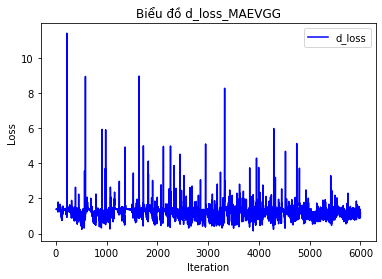

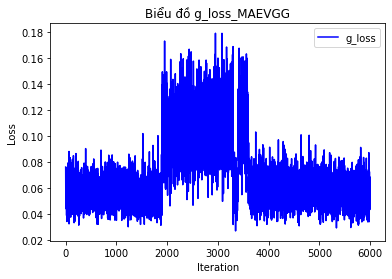

In [20]:
plot_losses(losses_list[0],label='d_loss',title='Biểu đồ d_loss_MAEVGG',figure=1)
plot_losses(losses_list[5],label='g_loss',title='Biểu đồ g_loss_MAEVGG',figure=2)

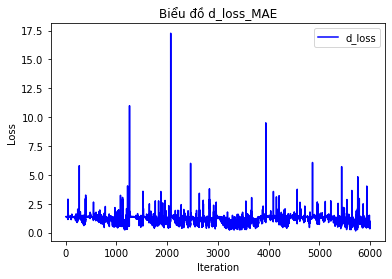

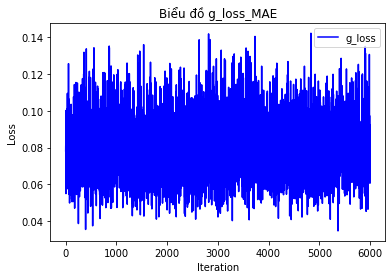

In [21]:
plot_losses(losses_list[1],label='d_loss',title='Biểu đồ d_loss_MAE',figure=3)
plot_losses(losses_list[6],label='g_loss',title='Biểu đồ g_loss_MAE',figure=4)

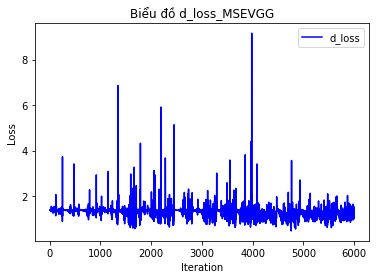

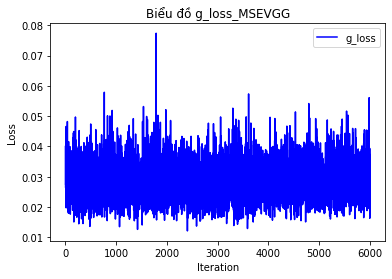

In [22]:
plot_losses(losses_list[2],label='d_loss',title='Biểu đồ d_loss_MSEVGG',figure=5)
plot_losses(losses_list[7],label='g_loss',title='Biểu đồ g_loss_MSEVGG',figure=6)

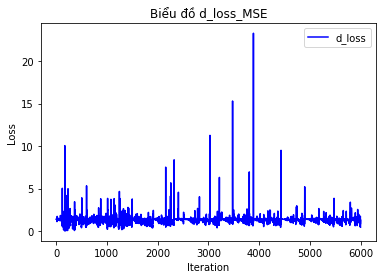

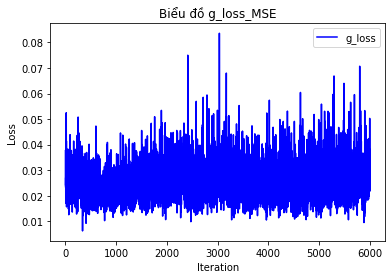

In [23]:
plot_losses(losses_list[3],label='d_loss',title='Biểu đồ d_loss_MSE',figure=7)
plot_losses(losses_list[8],label='g_loss',title='Biểu đồ g_loss_MSE',figure=8)

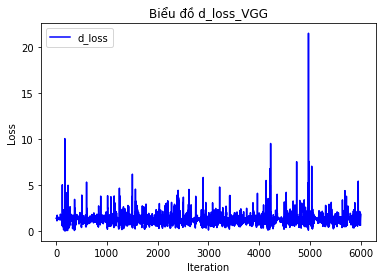

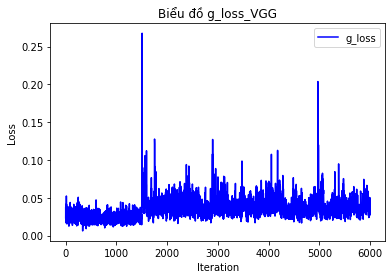

In [24]:
plot_losses(losses_list[4],label='d_loss',title='Biểu đồ d_loss_VGG',figure=9)
plot_losses(losses_list[9],label='g_loss',title='Biểu đồ g_loss_VGG',figure=10)

## 2. Đánh giá các điểm benchmark trên các tập Set5, Set14

In [2]:
def load_dataset(path):
    # remove images in '.ipynb_checkpoints'
    checkpoint = os.path.join(path, '.ipynb_checkpoints')
    if(os.path.exists(checkpoint)):
        for img_path in list(list_images(checkpoint)):
            os.remove(img_path)
    # read images
    img_list = list(list_images(path))
    imgs = tl.vis.read_images(img_list,printable=False,n_threads=32)
    return imgs

In [3]:
def compute_score(path_ori, path_sr):
    '''
    Compute PSNR and SSIM score between original images and super resolution images
        path_ori: path to original images directory
        path_sr: path to super resolution images directory
        (images' name in path_ori and path_sr must be the same)
    '''
    ori_imgs = load_dataset(path_ori)
    sr_imgs = load_dataset(path_sr)
#     print(len(ori_imgs))
    PSNR_scores = []
    SSIM_scores = []
    for ori_img,sr_img in zip(ori_imgs,sr_imgs):
#         print(ori_img.shape) # height width
#         print(sr_img.shape)
        height, width = ori_img.shape[:2]
        if height%4 != 0:
            height = height-height%4
        if width%4 != 0:
            width = width-width%4
        ori_img=ori_img[:height,:width]
        PSNR_scores.append(PSNR(ori_img,sr_img))
        SSIM_scores.append(SSIM(ori_img,sr_img, multichannel=True))
    mean_PSNR_score = np.mean(np.array(PSNR_scores))
    mean_SSIM_score = np.mean(np.array(SSIM_scores))
    return mean_PSNR_score, mean_SSIM_score

In [4]:
def gen_sr(lr_path,sr_path,model_weight_path):
    '''
    Generate super resolution images from low resolution images
        lr_path: path to low resolution images directory
        sr_path: path to super resolution images directory
        model_path: path to model
    '''
    tl.files.exists_or_mkdir(sr_path,verbose=False)
    lr_img_list = list(list_images(lr_path))
    lr_imgs = tl.vis.read_images(lr_img_list, n_threads=32)

    name = [os.path.split(path)[-1] for path in lr_img_list]

    ###========================== DEFINE MODEL ============================###
    temp = []
    for img in lr_imgs:
        normalized_img = img/127.5 - 1.
        temp.append(normalized_img)

    G = get_G([None, None, 3])
    G.load_weights(model_weight_path)

    for img,name in zip(temp,name):
        img = img[np.newaxis,:,:,:]
        out = G(img).numpy()
        tl.vis.save_image(out[0], os.path.join(sr_path, name))

In [2]:
def gen_img(lr_path,sr_path,model_weight_path):
    '''
    Generate single super resolution image from low resolution image
        lr_path: path to low resolution image
        sr_path: path to super resolution image
        model_path: path to model
    '''
    img = cv2.imread(lr_path)
    img = img[:,:,::-1]
    normalized_img = img/127.5 - 1.

    G = get_G([None, None, 3])
    G.load_weights(model_weight_path)

    normalized_img = normalized_img[np.newaxis,:,:,:]
    out = G(normalized_img).numpy()
    tl.vis.save_image(out[0], sr_path)

In [ ]:
gen_img('archive/Set14_lr/zebra.png','quang.jpg','results/g_maevgg_60.h5')

In [3]:
gen_img('black.jpg','quang_black.jpg','results/g_maevgg_60.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Lossy conversion from float32 to uint8. Range [-0.9970982670783997, -0.255833238363266]. Convert image to uint8 prior to saving to suppress this warning.


In [31]:
generators_list = list(imutils.paths.list_files('results',validExts='h5'))
generators_list

['results\\g_maevgg_60.h5',
 'results\\g_mae_60.h5',
 'results\\g_msevgg_60.h5',
 'results\\g_mse_60.h5',
 'results\\g_vgg_60.h5',
 'results\\g_warmed_up.h5']

In [ ]:
# gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_maevgg',model_weight_path=generators_list[0])
# gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_mae',model_weight_path=generators_list[1])
# gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_msevgg',model_weight_path=generators_list[2])
# gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_mse',model_weight_path=generators_list[3])
# gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_vgg',model_weight_path=generators_list[4])
gen_sr(lr_path='archive/Set5_lr',sr_path='archive/Set5_sr_warmedup',model_weight_path=generators_list[5])

# gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_maevgg',model_weight_path=generators_list[0])
# gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_mae',model_weight_path=generators_list[1])
# gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_msevgg',model_weight_path=generators_list[2])
# gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_mse',model_weight_path=generators_list[3])
# gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_vgg',model_weight_path=generators_list[4])
gen_sr(lr_path='archive/Set14_lr',sr_path='archive/Set14_sr_warmedup',model_weight_path=generators_list[5])

# gen_sr(lr_path='archive/BSD100_lr',sr_path='archive/BSD100_sr_maevgg',model_weight_path=generators_list[0])
# gen_sr(lr_path='archive/BSD100_lr',sr_path='archive/BSD100_sr_mae',model_weight_path=generators_list[1])
# gen_sr(lr_path='archive/BSD100_lr',sr_path='archive/BSD100_sr_msevgg',model_weight_path=generators_list[2])
# gen_sr(lr_path='archive/BSD100_lr',sr_path='archive/BSD100_sr_mse',model_weight_path=generators_list[3])
# gen_sr(lr_path='archive/BSD100_lr',sr_path='archive/BSD100_sr_vgg',model_weight_path=generators_list[4])
gen_sr(lr_path='archive/BSD100_lr',sr_path='archive/BSD100_sr_warmedup',model_weight_path=generators_list[5])

In [33]:
# Calculate scores on Set5
PSNR_score_Set5_bicu, SSIM_score_Set5_bicu = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_bicubic')
PSNR_score_Set5_mae, SSIM_score_Set5_mae = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_mae')
PSNR_score_Set5_maevgg, SSIM_score_Set5_maevgg = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_maevgg')
PSNR_score_Set5_mse, SSIM_score_Set5_mse = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_mse')
PSNR_score_Set5_msevgg, SSIM_score_Set5_msevgg = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_msevgg')
PSNR_score_Set5_vgg, SSIM_score_Set5_vgg = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_vgg')
PSNR_score_Set5_warmedup, SSIM_score_Set5_warmedup = compute_score(path_ori='archive/Set5', path_sr='archive/Set5_sr_warmedup')

In [36]:
# Calculate scores on Set14
PSNR_score_Set14_bicu, SSIM_score_Set14_bicu = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_bicubic')
PSNR_score_Set14_mae, SSIM_score_Set14_mae = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_mae')
PSNR_score_Set14_maevgg, SSIM_score_Set14_maevgg = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_maevgg')
PSNR_score_Set14_mse, SSIM_score_Set14_mse = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_mse')
PSNR_score_Set14_msevgg, SSIM_score_Set14_msevgg = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_msevgg')
PSNR_score_Set14_vgg, SSIM_score_Set14_vgg = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_vgg')
PSNR_score_Set14_warmedup, SSIM_score_Set14_warmedup = compute_score(path_ori='archive/Set14', path_sr='archive/Set14_sr_warmedup')

In [37]:
# Calculate scores on BSD100
PSNR_score_BSD100_bicu, SSIM_score_BSD100_bicu = compute_score(path_ori='archive/BSD100', path_sr='archive/BSD100_bicubic')
PSNR_score_BSD100_mae, SSIM_score_BSD100_mae = compute_score(path_ori='archive/BSD100', path_sr='archive/BSD100_sr_mae')
PSNR_score_BSD100_maevgg, SSIM_score_BSD100_maevgg = compute_score(path_ori='archive/BSD100', path_sr='archive/BSD100_sr_maevgg')
PSNR_score_BSD100_mse, SSIM_score_BSD100_mse = compute_score(path_ori='archive/BSD100', path_sr='archive/BSD100_sr_mse')
PSNR_score_BSD100_msevgg, SSIM_score_BSD100_msevgg = compute_score(path_ori='archive/BSD100', path_sr='archive/BSD100_sr_msevgg')
PSNR_score_BSD100_vgg, SSIM_score_BSD100_vgg = compute_score(path_ori='archive/BSD100', path_sr='archive/BSD100_sr_vgg')
PSNR_score_BSD100_warmedup, SSIM_score_BSD100_warmedup = compute_score(path_ori='archive/BSD100', path_sr='archive/BSD100_sr_warmedup')

In [18]:
print('PSNR_score bicubic on Set5: ',PSNR_score_Set5_bicu)
print('PSNR_score bicubic on Set14: ',PSNR_score_Set14_bicu)
print('PSNR_score bicubic on BSD100: ',PSNR_score_BSD100_bicu)
print('SSIM_score bicubic on Set5: ',SSIM_score_Set5_bicu)
print('SSIM_score bicubic on Set14: ',SSIM_score_Set14_bicu)
print('SSIM_score bicubic on BSD100: ',SSIM_score_BSD100_bicu)

PSNR_score bicubic on Set5:  24.692742159215438
PSNR_score bicubic on Set14:  23.07668644165525
PSNR_score bicubic on BSD100:  23.83144616655558
SSIM_score bicubic on Set5:  0.7424393312422184
SSIM_score bicubic on Set14:  0.6623793918240392
SSIM_score bicubic on BSD100:  0.6469835090155294


In [17]:
print('PSNR_score MAE on Set5: ',PSNR_score_Set5_mae)
print('PSNR_score MAE on Set14: ',PSNR_score_Set14_mae)
print('PSNR_score MAE on BSD100: ',PSNR_score_BSD100_mae)
print('SSIM_score MAE on Set5: ',SSIM_score_Set5_mae)
print('SSIM_score MAE on Set14: ',SSIM_score_Set14_mae)
print('SSIM_score MAE on BSD100: ',SSIM_score_BSD100_mae)

PSNR_score MAE on Set5:  26.27470577023101
PSNR_score MAE on Set14:  23.52473266914299
PSNR_score MAE on BSD100:  22.96655145221955
SSIM_score MAE on Set5:  0.7678944973544419
SSIM_score MAE on Set14:  0.666770461978822
SSIM_score MAE on BSD100:  0.6471863818467043


In [19]:
print('PSNR_score MAEVGG on Set5: ',PSNR_score_Set5_maevgg)
print('PSNR_score MAEVGG on Set14: ',PSNR_score_Set14_maevgg)
print('PSNR_score MAEVGG on BSD100: ',PSNR_score_BSD100_maevgg)
print('SSIM_score MAEVGG on Set5: ',SSIM_score_Set5_maevgg)
print('SSIM_score MAEVGG on Set14: ',SSIM_score_Set14_maevgg)
print('SSIM_score MAEVGG on BSD100: ',SSIM_score_BSD100_maevgg)

PSNR_score MAEVGG on Set5:  26.293183320059228
PSNR_score MAEVGG on Set14:  23.610068547269204
PSNR_score MAEVGG on BSD100:  22.93355803801944
SSIM_score MAEVGG on Set5:  0.7682070267655291
SSIM_score MAEVGG on Set14:  0.6689556047860895
SSIM_score MAEVGG on BSD100:  0.6377506124906673


In [20]:
print('PSNR_score MSE on Set5: ',PSNR_score_Set5_mse)
print('PSNR_score MSE on Set14: ',PSNR_score_Set14_mse)
print('PSNR_score MSE on BSD100: ',PSNR_score_BSD100_mse)
print('SSIM_score MSE on Set5: ',SSIM_score_Set5_mse)
print('SSIM_score MSE on Set14: ',SSIM_score_Set14_mse)
print('SSIM_score MSE on BSD100: ',SSIM_score_BSD100_mse)

PSNR_score MSE on Set5:  24.043752889789104
PSNR_score MSE on Set14:  22.57600340472553
PSNR_score MSE on BSD100:  22.593564892991647
SSIM_score MSE on Set5:  0.6370645922394571
SSIM_score MSE on Set14:  0.5677713019867374
SSIM_score MSE on BSD100:  0.5529288093446497


In [21]:
print('PSNR_score MSEVGG on Set5: ',PSNR_score_Set5_msevgg)
print('PSNR_score MSEVGG on Set14: ',PSNR_score_Set14_msevgg)
print('PSNR_score MSEVGG on BSD100: ',PSNR_score_BSD100_msevgg)
print('SSIM_score MSEVGG on Set5: ',SSIM_score_Set5_msevgg)
print('SSIM_score MSEVGG on Set14: ',SSIM_score_Set14_msevgg)
print('SSIM_score MSEVGG on BSD100: ',SSIM_score_BSD100_msevgg)

PSNR_score MSEVGG on Set5:  26.096715185060198
PSNR_score MSEVGG on Set14:  23.4622318000562
PSNR_score MSEVGG on BSD100:  22.999464072669483
SSIM_score MSEVGG on Set5:  0.7547764712159497
SSIM_score MSEVGG on Set14:  0.6618903328025855
SSIM_score MSEVGG on BSD100:  0.6429545063680321


In [22]:
print('PSNR_score VGG on Set5: ',PSNR_score_Set5_vgg)
print('PSNR_score VGG on Set14: ',PSNR_score_Set14_vgg)
print('PSNR_score VGG on BSD100: ',PSNR_score_BSD100_vgg)
print('SSIM_score VGG on Set5: ',SSIM_score_Set5_vgg)
print('SSIM_score VGG on Set14: ',SSIM_score_Set14_vgg)
print('SSIM_score VGG on BSD100: ',SSIM_score_BSD100_vgg)

PSNR_score VGG on Set5:  20.1018894979267
PSNR_score VGG on Set14:  19.228958107434586
PSNR_score VGG on BSD100:  19.208380969309445
SSIM_score VGG on Set5:  0.5849774336485116
SSIM_score VGG on Set14:  0.5055497594059203
SSIM_score VGG on BSD100:  0.5009242600079552


In [38]:
print('PSNR_score G_warmed_up on Set5: ',PSNR_score_Set5_warmedup)
print('PSNR_score G_warmed_up on Set14: ',PSNR_score_Set14_warmedup)
print('PSNR_score G_warmed_up on BSD100: ',PSNR_score_BSD100_warmedup)
print('SSIM_score G_warmed_up on Set5: ',SSIM_score_Set5_warmedup)
print('SSIM_score G_warmed_up on Set14: ',SSIM_score_Set14_warmedup)
print('SSIM_score G_warmed_up on BSD100: ',SSIM_score_BSD100_warmedup)

PSNR_score G_warmed_up on Set5:  26.34007579271856
PSNR_score G_warmed_up on Set14:  23.656454069304488
PSNR_score G_warmed_up on BSD100:  22.77173495525079
SSIM_score G_warmed_up on Set5:  0.7778457596773654
SSIM_score G_warmed_up on Set14:  0.6780710026970603
SSIM_score G_warmed_up on BSD100:  0.652017121676774


In [ ]:
if __name__ == '__main__':
    import argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("-hr", "--high-reso", type=str, default='archive/Set5', help="path to high resolution images directory")
    ap.add_argument("-sr", "--super-reso", type=str, default='archive/Set5_sr', help="path to super resolution images directory")

    args = vars(ap.parse_args())

    PSNR_score, SSIM_score = compute_score(args['high_reso'], args['super_reso'])
    print('PSNR_score = ',PSNR_score)
    print('SSIM_score = ',SSIM_score)    